In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#imnport libraries 
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import seaborn as sn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


In [0]:
#import csv files 
train = pd.read_csv('/content/drive/My Drive/ML_coursework/train.csv')
test = pd.read_csv('/content/drive/My Drive/ML_coursework/test.csv')
submission = pd.read_csv('/content/drive/My Drive/ML_coursework/sampleSubmission.csv')

In [0]:
#covert to dataframe
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

In [0]:
# Load data
train_df.head(3)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no


In [0]:
# Load data
test_df.head(3)

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4


In [0]:
label_encoder = preprocessing.LabelEncoder()

train_df['international_plan'] = label_encoder.fit_transform(train_df['international_plan'])
train_df['voice_mail_plan'] = label_encoder.fit_transform(train_df['voice_mail_plan'])
train_df['churn'] = label_encoder.fit_transform(train_df['churn'])

In [0]:
#merge all matching features 
train_df['total_minutes']=train_df.total_day_minutes + train_df.total_eve_minutes + train_df.total_night_minutes + train_df.total_intl_minutes
train_df['total_calls']=train_df.total_day_calls + train_df.total_eve_calls + train_df.total_night_calls + train_df.total_intl_calls
train_df['total_charge']=train_df.total_day_charge + train_df.total_eve_charge + train_df.total_night_charge + train_df.total_intl_charge
train_df['total_hours'] = train_df.total_minutes/60

In [0]:
# Load data
train_df.head(3)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_calls,total_charge,total_hours
0,OH,107,area_code_415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,625.2,332,59.24,10.420000
1,NJ,137,area_code_415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,539.4,333,62.29,8.990000
2,OH,84,area_code_408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,564.8,255,66.80,9.413333


In [0]:
#check if we have unique values 
train_df.describe(include=['O'])

,state,area_code
count,4250,4250
unique,51,3
top,WV,area_code_415
freq,139,2108


In [0]:
# Create two bins for State based on the proportion of churners
dn = train_df.groupby(by='state').agg(lambda x: x.sum()/ x.count()).reset_index()
np.mean(dn.churn.values)
group_A = (dn.loc[dn.churn>0.14]).state.values
group_B = (dn.loc[dn.churn<=0.14]).state.values


# Convert State and Area_code into dummies 
def preprocess(df):
    df_dummies = pd.get_dummies(df.area_code) 
    df=pd.concat([df_dummies,df],axis=1)
    
    for i in group_A:
        for j in group_B:
            df.state.replace((i,j), ('group_A','group_B'), inplace=True)
    
    df_dummies2 = pd.get_dummies(df.state)
    df=pd.concat([df_dummies2,df],axis=1)
    
    df.drop(['state','area_code'],inplace=True,axis=1)
    return df
	

train_df=preprocess(train_df)

In [0]:
def plot_distribution_num(dftrain):
    sns.set_style("ticks")
    s = sns.FacetGrid(train_df,hue = 'churn',aspect = 2.5, palette='Set1')
    s.map(sns.kdeplot,dftrain, shade = True, alpha = 0.8)
    s.set(xlim=(0, train_df[dftrain].max()))
    s.add_legend()
    s.fig.suptitle(dftrain)
    plt.show()

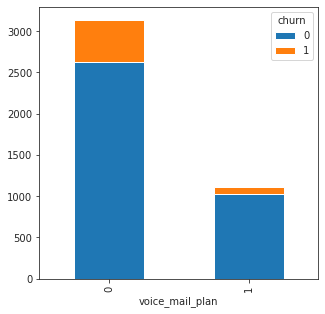

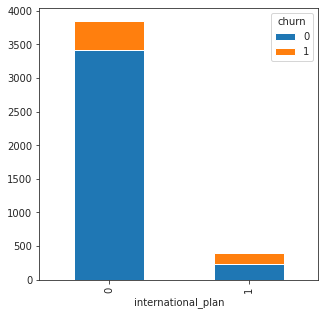

In [0]:
#Plot group by churn by State
#Churn By Customers with Voice mail plan
train_df.groupby(["voice_mail_plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 
#Plot churn By Customers with International plan
train_df.groupby(["international_plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

num of pepole who stay: 3652
num of pepole who churn: 598


Text(0.5, 1.0, 'Balance of Dataset')

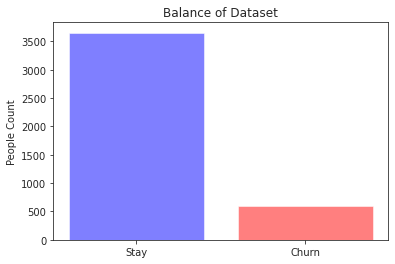

In [0]:
#check if dataset is balance
stay = train_df[(train_df['churn'] ==0) ].count()[1]
churn = train_df[(train_df['churn'] ==1) ].count()[1]
print ("num of pepole who stay: "+ str(stay))
print ("num of pepole who churn: "+ str(churn))

#plot the balance of dataset
objects = ('Stay', 'Churn')
y_pos = np.arange(len(objects))
performance = [stay,churn]
plt.bar(y_pos, performance, align='center', alpha=0.5, color=['blue', 'red'])
plt.xticks(y_pos, objects)
plt.ylabel('People Count')
plt.title('Balance of Dataset')

In [0]:
#check Churn percentage
y_True = train_df["churn"][train_df["churn"] == True]
print ("Churn Percentage = "+str( (y_True.shape[0] / train_df["churn"].shape[0]) * 100 ))

Churn Percentage = 14.070588235294117


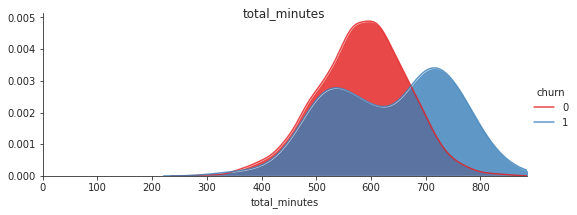

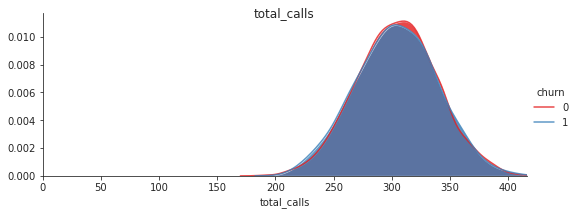

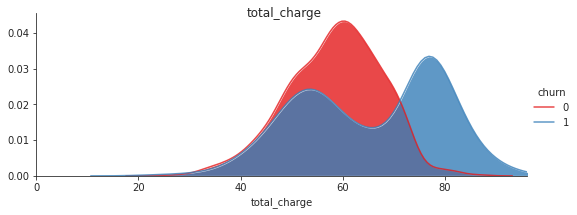

In [0]:
# plot the distribution of the numerical features 
plot_distribution_num('total_minutes')
plot_distribution_num('total_calls')
plot_distribution_num('total_charge')

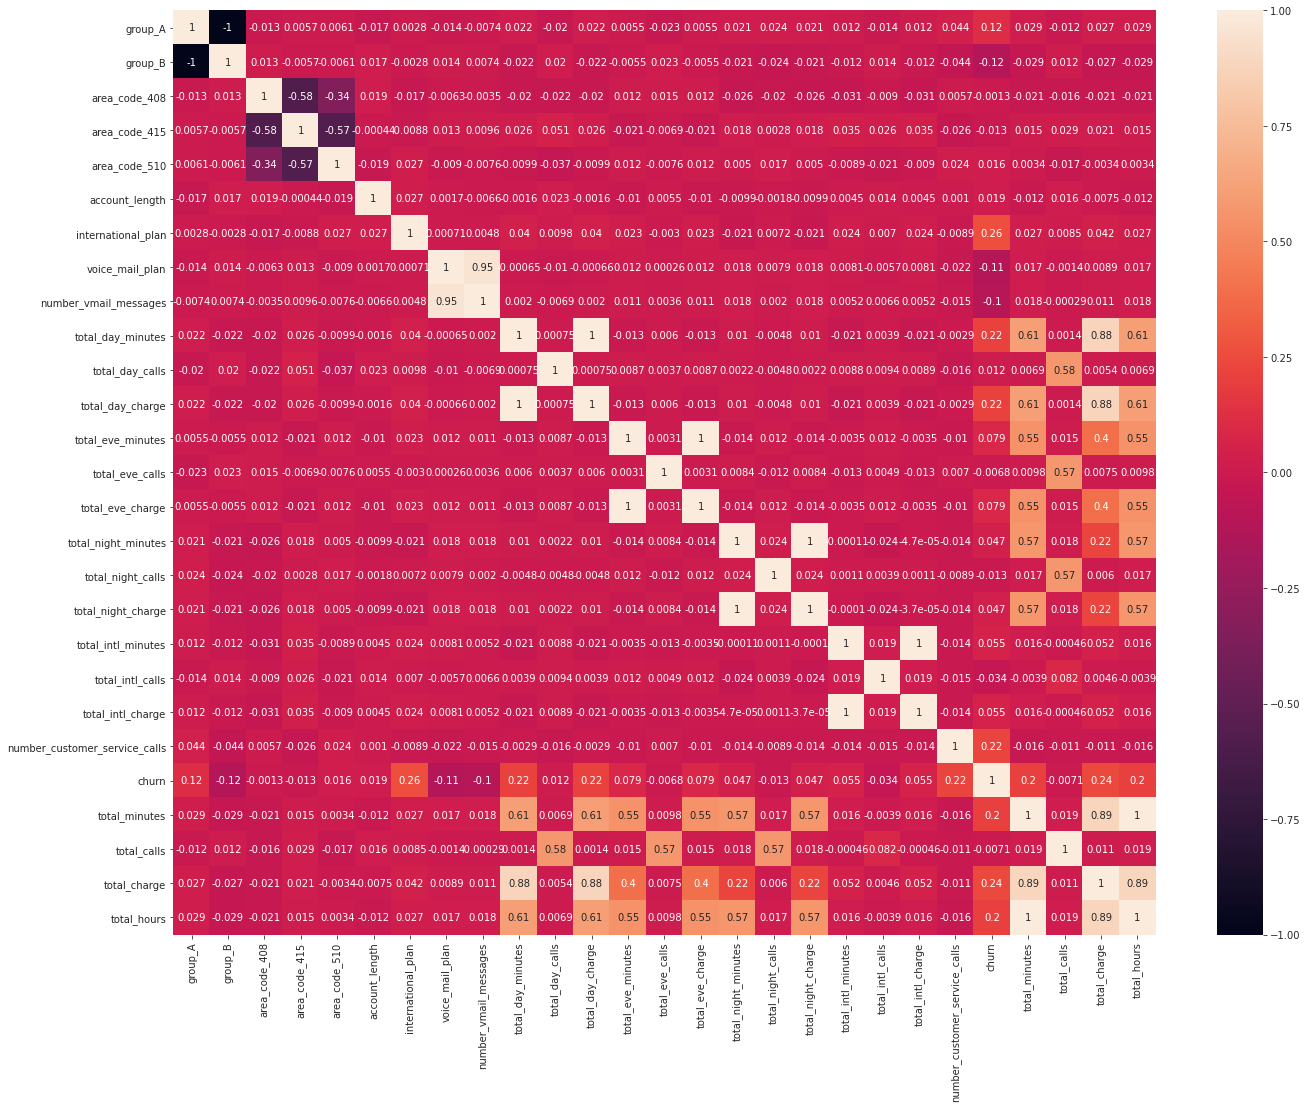

In [0]:
# make the correlation matrix
corrMatrix = train_df.corr()
plt.figure(figsize=(22,17))
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [0]:
X = train_df.drop('churn',axis=1)
y = train_df.churn
#slipt our dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, y_train.shape, X_test.shape , y_test.shape

((2975, 26), (2975,), (1275, 26), (1275,))

In [0]:
# Over Sampling to set balance into dataset
sm = SMOTE(random_state=0, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
#data labels before SMOTE:
import collections
collections.Counter(y_train)

Counter({0: 2550, 1: 425})

In [0]:
#after SMOTE:
import collections
collections.Counter(y_train_res)

Counter({0: 2550, 1: 2550})

In [0]:
#Hyper Parameters Set Desicion Tree 
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[123]}
#Set up parameters to tune Decision Tree Classifier
des_tree = DecisionTreeClassifier(random_state=1234)
grid_des_tree  = GridSearchCV(estimator = des_tree, param_grid = params, cv = 5)
best_dt = grid_des_tree.fit(X_train, y_train)
print(best_dt.best_params_)

{'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 13, 'random_state': 123}


In [0]:
#set up the optimimzed classifier Desicion Tree
opt_des_tree = DecisionTreeClassifier(max_depth=3 , random_state=123)
opt_des_tree.fit(X_train,y_train)
print('Accuracy of the GBM on test set: {:.3f}'.format(opt_des_tree.score(X_test, y_test)))
tree_pred=opt_des_tree.predict(X_test)
print(classification_report(y_test, tree_pred))

Accuracy of the GBM on test set: 0.950
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1102
           1       1.00      0.63      0.77       173

    accuracy                           0.95      1275
   macro avg       0.97      0.82      0.87      1275
weighted avg       0.95      0.95      0.94      1275



In [0]:
#Set up parameters to tune Gradient booster
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]}
#Set up Base model Gradient Booster
gbc = GradientBoostingClassifier()
grid_gb  = GridSearchCV(estimator = gbc, param_grid = parameters, cv = 5)
best_gb = grid_gb.fit(X_train, y_train)
print(best_gb.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


In [0]:
#set up the optimimzed classifier GBooster
opt_GB=GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,max_depth=3, min_samples_split=2, min_samples_leaf=7 , max_features=5 )
opt_GB.fit(X_train,y_train)
print('Accuracy of the GBM on test set: {:.3f}'.format(opt_GB.score(X_test, y_test)))
gb_pred=opt_GB.predict(X_test)
print(classification_report(y_test, gb_pred))

Accuracy of the GBM on test set: 0.973
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1102
           1       1.00      0.80      0.89       173

    accuracy                           0.97      1275
   macro avg       0.99      0.90      0.94      1275
weighted avg       0.97      0.97      0.97      1275



In [0]:
# defining parameter range in SVM 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
#Set Up the optimized SVC classifier
grid = GridSearchCV(SVC(), param_grid, cv = 5, refit = True, verbose = 3) 
grid.fit(X_train, y_train) 
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.857, total=   0.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   59.2s finished


{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}


In [0]:
# SVM classifier
svm = SVC(C = 1, kernel='rbf' , gamma  =0.001, probability=True)
svm.fit(X_train,y_train)
print('Accuracy of the GBM on test set: {:.3f}'.format(svm.score(X_test, y_test)))
svm_pred=svm.predict(X_test)
print(classification_report(y_test, svm_pred))


Accuracy of the GBM on test set: 0.867
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1102
           1       1.00      0.02      0.05       173

    accuracy                           0.87      1275
   macro avg       0.93      0.51      0.49      1275
weighted avg       0.89      0.87      0.81      1275



In [0]:
#Set parameters to choose Random Forest
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)
# Create a based model
forest = RandomForestClassifier()
gridF  = GridSearchCV(estimator = forest, param_grid = hyperF, cv = 3, n_jobs = -1, verbose = 2)
bestF = gridF.fit(X_train, y_train)
print(bestF.best_params_)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.2s


KeyboardInterrupt: ignored

In [0]:
#Optimized Random Forest Classifier
forestOpt = RandomForestClassifier(random_state = 1, max_depth = 25,n_estimators = 800, min_samples_split = 2, min_samples_leaf = 2)    
forestOpt.fit(X_train,y_train)
print('Accuracy of the GBM on test set: {:.3f}'.format(forestOpt.score(X_test, y_test)))
fpred=forestOpt.predict(X_test)
print(classification_report(y_test, fpred))

Accuracy of the GBM on test set: 0.979
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1102
           1       1.00      0.84      0.92       173

    accuracy                           0.98      1275
   macro avg       0.99      0.92      0.95      1275
weighted avg       0.98      0.98      0.98      1275



In [0]:
#Making confusion matrix 
forest_cm = metrics.confusion_matrix(fpred,y_test)
print("Confusion Matrix of random forest:\n",forest_cm)
tree_cm = metrics.confusion_matrix(tree_pred,y_test)
print("Confusion Matrix of Desicion Tree:\n",tree_cm)
gradient_boooster_cm = metrics.confusion_matrix(gb_pred,y_test)
print("Confusion Matrix of Gradient booster :\n",gradient_boooster_cm)
SVM_cm = metrics.confusion_matrix(svm_pred,y_test)
print("Confusion Matrix of SVM:\n",SVM_cm)


Confusion Matrix of random forest:
 [[1102   27]
 [   0  146]]
Confusion Matrix of Desicion Tree:
 [[1102   64]
 [   0  109]]
Confusion Matrix of Gradient booster :
 [[1102   34]
 [   0  139]]
Confusion Matrix of SVM:
 [[1102  169]
 [   0    4]]


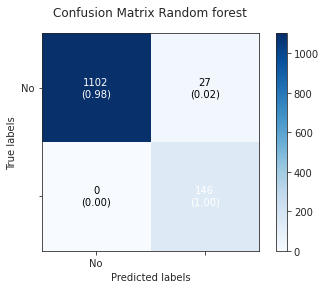

In [0]:
#confusion matrix plot knn
fig, ax = plot_confusion_matrix(conf_mat=forest_cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Random forest'); 
ax.xaxis.set_ticklabels(['Yes', 'No']); ax.yaxis.set_ticklabels(['Yes', 'No']);
plt.show()

In [0]:
# Applying k-Fold cross validation
score_forest = cross_val_score(estimator=forestOpt, X=X_test, y=y_test, cv=10)
score_opt_GB = cross_val_score(estimator=opt_GB, X=X_test, y=y_test, cv=10)
score_des_tree = cross_val_score(estimator=opt_des_tree, X=X_test, y=y_test, cv=10)
score_svc = cross_val_score(estimator=svm, X=X_test, y=y_test, cv=10)
print('Accuracy mean from k-Fold cross validation on Random Forest:', score_forest.mean())
print('Accuracy mean from k-Fold cross validation on Gradient Booster:', score_opt_GB.mean())
print('Accuracy mean from k-Fold cross validation on Decision Tree:', score_des_tree.mean())
print('Accuracy mean from k-Fold cross validation on SVM:', score_svc.mean())


Accuracy mean from k-Fold cross validation on Random Forest: 0.9639456200787402
Accuracy mean from k-Fold cross validation on Gradient Booster: 0.9670767716535433
Accuracy mean from k-Fold cross validation on Decision Tree: 0.947447096456693
Accuracy mean from k-Fold cross validation on SVM: 0.8651021161417323


([<matplotlib.axis.YTick at 0x7f0991fa40b8>,
 [Text(0, 0, 'group_A'),
  Text(0, 0, 'group_B'),
  Text(0, 0, 'area_code_408'),
  Text(0, 0, 'area_code_415'),
  Text(0, 0, 'area_code_510'),
  Text(0, 0, 'account_length'),
  Text(0, 0, 'international_plan'),
  Text(0, 0, 'voice_mail_plan'),
  Text(0, 0, 'number_vmail_messages'),
  Text(0, 0, 'total_day_minutes'),
  Text(0, 0, 'total_day_calls'),
  Text(0, 0, 'total_day_charge'),
  Text(0, 0, 'total_eve_minutes'),
  Text(0, 0, 'total_eve_calls'),
  Text(0, 0, 'total_eve_charge'),
  Text(0, 0, 'total_night_minutes'),
  Text(0, 0, 'total_night_calls'),
  Text(0, 0, 'total_night_charge'),
  Text(0, 0, 'total_intl_minutes'),
  Text(0, 0, 'total_intl_calls'),
  Text(0, 0, 'total_intl_charge'),
  Text(0, 0, 'number_customer_service_calls'),
  Text(0, 0, 'churn'),
  Text(0, 0, 'total_minutes'),
  Text(0, 0, 'total_calls'),
  Text(0, 0, 'total_charge')])

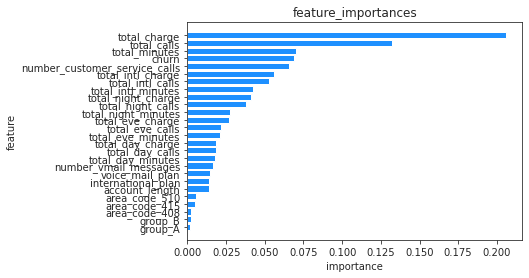

In [0]:
feature_importance = forestOpt.feature_importances_
feat_importances = pd.Series(forestOpt.feature_importances_, index=train_df.columns[:-1])
feat_importances = feat_importances.nlargest(19)

feature = train_df.columns.values.tolist()[0:-1]
importance = sorted(forestOpt.feature_importances_.tolist())


x_pos = [i for i, _ in enumerate(feature)]
# 
plt.barh(x_pos, importance , color='dodgerblue')
plt.ylabel("feature")
plt.xlabel("importance")
plt.title("feature_importances")

plt.yticks(x_pos, feature)

In [0]:
#calculate values for ROC AUC plot

#SVM model
svm_roc = roc_auc_score(y_test, svm.predict(X_test))
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
#Random Forest model
random_forest_roc = roc_auc_score(y_test, forestOpt.predict(X_test))
fprnew, tprnew, thresholds_new = roc_curve(y_test, forestOpt.predict_proba(X_test)[:,1])
#Gradient booster model
gradient_booster_roc = roc_auc_score(y_test, opt_GB.predict(X_test))
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, opt_GB.predict_proba(X_test)[:,1])
#Desicion Tree model
decision_tree_roc = roc_auc_score(y_test, opt_des_tree.predict(X_test))
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, opt_des_tree.predict_proba(X_test)[:,1])


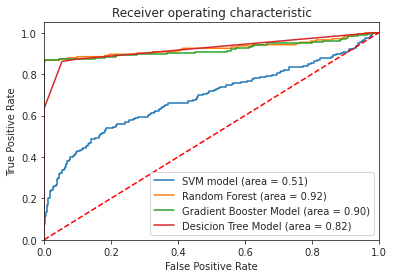

In [0]:
plt.figure()
plt.plot(fpr_svm, tpr_svm, label='SVM model (area = %0.2f)' % svm_roc)
plt.plot(fprnew, tprnew, label='Random Forest (area = %0.2f)' % random_forest_roc)
plt.plot(fpr_gb, tpr_gb, label='Gradient Booster Model (area = %0.2f)' % gradient_booster_roc)
plt.plot(fpr_dt, tpr_dt, label='Desicion Tree Model (area = %0.2f)' % decision_tree_roc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [0]:
test_df['international_plan'] = label_encoder.fit_transform(test_df['international_plan'])
test_df['voice_mail_plan'] = label_encoder.fit_transform(test_df['voice_mail_plan'])


test_df['total_mins']=test_df.total_day_minutes + test_df.total_eve_minutes + test_df.total_night_minutes + test_df.total_intl_minutes
test_df['total_calls']=test_df.total_day_calls + test_df.total_eve_calls + test_df.total_night_calls + test_df.total_intl_calls
test_df['total_charge']=test_df.total_day_charge + test_df.total_eve_charge + test_df.total_night_charge + test_df.total_intl_charge

test_df=preprocess(test_df)

In [0]:
#drop id column
X_test = test_df.drop(["id"], axis = 1)


In [0]:
X_test['total_hours'] = X_test.total_mins/60

In [0]:
algo_name = forestOpt
algo_name.fit(X, y)
Y_pred = algo_name.predict(X_test)

In [0]:
Y_pred = np.where(Y_pred==0, 'no', Y_pred)

In [0]:
Y_pred = np.where(Y_pred=='1', 'yes', Y_pred)

In [0]:
output = pd.DataFrame({'id': test.id, 'churn': Y_pred})
output.to_csv('Random_forest_Churn.csv', index=False)